In [1]:
from bokeh.io import output_notebook, push_notebook, show
output_notebook()

Loading BokehJS ...

Les classes "base" regroupent les attributs et les méthodes utiles pour qu'IBEX puisse interroger la boîte noire et accéder à la population associée. Elles gèrent en particulier les variables catégorielles et les représentations de données le cas échéant (base image et texte, cf plus bas). 

In [2]:
from data.db_example import * 

base = GermanBase() # other choices (tabular) : IrisBase, AdultBase, GermanBase, LoanBase

print("Model outputs", base.model(base.population.head(5)))
base.population.head(5)

Model outputs [ True False  True False False]


/home/clement/anaconda3/envs/ibexenv/lib/python3.8/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.23.2 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
/home/clement/anaconda3/envs/ibexenv/lib/python3.8/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 0.23.2 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


credit_amount  duration              purpose  existing_credits  \
0           1169         6             radio/tv                 2   
1           5951        48             radio/tv                 1   
2           2096        12            education                 1   
3           7882        42  furniture/equipment                 1   
4           4870        24            'new car'                 2   

                     credit_history other_payment_plans   property_magnitude  \
0  'critical/other existing credit'                none        'real estate'   
1                   'existing paid'                none        'real estate'   
2  'critical/other existing credit'                none        'real estate'   
3                   'existing paid'                none     'life insurance'   
4              'delayed previously'                none  'no known property'   

      housing checking_status      savings_status employment  \
0         own            '<0'  'no known savings'      '>=7'   
1         own      '0<=X<200'              '<100'   '1<=X<4'   
2         own   'no checking'              '<100'   '4<=X<7'   
3  'for free'            '<0'              '<100'   '4<=X<7'   
4  'for free'            '<0'              '<100'   '1<=X<4'   

                    job  age  num_dependents  installment_commitment  \
0               skilled   67               1                       4   
1               skilled   22               1                       2   
2  'unskilled resident'   49               2                       2   
3               skilled   45               2                       2   
4               skilled   53               2                       3   

  own_telephone       personal_status foreign_worker other_parties  \
0           yes         'male single'            yes          none   
1          none  'female div/dep/mar'            yes          none   
2          none         'male single'            yes          none   
3          none         'male single'            yes     guarantor   
4          none         'male single'            yes          none   

   residence_since  
0                4  
1                2  
2                3  
3                4  
4                4

## Calculer les explications locales avec IBEX

Pour obtenir une explication avec IBEX, il faut choisir un mode d'échantillonnage et un mode de génération. 
L'entrée de l'échantillonnage est la base choisie (plus les paramètres) et l'entrée de la génération sont les échantillons (plus les paramètres). 

In [3]:
# randomly selects the scope of the explanation
scope = base.population.sample(1)
scope_pred = base.model(scope)
print("Sortie de l'algorithme : ", base.class_names[int(scope_pred[0])])
scope

Sortie de l'algorithme :  bad


credit_amount  duration     purpose  existing_credits credit_history  \
889           7824        28  'used car'                 2     'all paid'   

    other_payment_plans property_magnitude housing checking_status  \
889                bank      'real estate'    rent   'no checking'   

         savings_status employment      job  age  num_dependents  \
889  'no known savings'       '<1'  skilled   40               2   

     installment_commitment own_telephone personal_status foreign_worker  \
889                       3           yes   'male single'            yes   

    other_parties  residence_since  
889     guarantor                4

### Sampling

In [4]:
from sampling.selection import * 
from sampling.perturbation import * 

# sampling method choice 
local_sampling_method = perturb_one_sample_w_pop # add_random_noise, perturb_one_sample_w_pop, select_closest
samples = local_sampling_method(base, scope)
samples.sample(5)

credit_amount  duration     purpose  existing_credits credit_history  \
111           7824        28  'used car'                 2     'all paid'   
763           7824        21  'used car'                 2     'all paid'   
541           2032        24   'new car'                 2     'all paid'   
606           7824        28    business                 2     'all paid'   
661            900        28  'used car'                 2     'all paid'   

    other_payment_plans   property_magnitude     housing checking_status  \
111                bank        'real estate'        rent   'no checking'   
763                bank        'real estate'        rent   'no checking'   
541                none  'no known property'  'for free'   'no checking'   
606                none        'real estate'        rent   'no checking'   
661                bank                  car        rent            '<0'   

         savings_status  ...      job age  num_dependents  \
111              '<100'  ...  skilled  40               2   
763  'no known savings'  ...  skilled  40               2   
541              '<100'  ...  skilled  60               1   
606  'no known savings'  ...  skilled  74               1   
661  'no known savings'  ...  skilled  23               2   

     installment_commitment  own_telephone personal_status foreign_worker  \
111                       3            yes   'male single'            yes   
763                       3            yes   'male single'            yes   
541                       4            yes   'male single'            yes   
606                       3            yes   'male single'            yes   
661                       4           none   'male single'            yes   

    other_parties residence_since  output  
111     guarantor               4   False  
763     guarantor               4    True  
541          none               4    True  
606     guarantor               4    True  
661          none               2   False  

[5 rows x 21 columns]

### Generation

In [5]:
from generation.rule_based_model import * 
from generation.features_specific import * 

expl_data = rule_based_model(base, scope, samples)  # feature_importance, rule_based_model

### Delivering

In [6]:
from delivering.f_specific_plot import * 
from delivering.rule_representation import * 

In [7]:
print(rbm_format_rule(expl_data))

Si checking_status est 'no checking'
 et savings_status n'est pas '<100'
 et savings_status n'est pas '>=1000', alors, dans un voisinage du périmètre, la sortie de l'algorithme est celle du périmètre avec une précision de 1.0 sur 302 échantillons. 


### Exemple 1 : modèle à base de règles + échantillonnage par permutation 

In [8]:
samples = perturb_one_sample_w_pop(base, scope, 
                                   # liste des paramètres pour l'échantillonnage 
                                   size=1000, 
#                                    n_col_distrib='normal', # distribution pour le nombre de colonne à permuter
#                                    normal_sigma=1, # deviation si la distribution choisie est gaussienne 
                                  )
expl_data = rule_based_model(base, scope, samples, 
                             # liste des paramètres pour la génération
                             min_accuracy=.5, # précision minimale pour les règles 
                            )
print(rbm_format_rule(expl_data))

Si checking_status est 'no checking', alors, dans un voisinage du périmètre, la sortie de l'algorithme est celle du périmètre avec une précision de 0.574 sur 759 échantillons. 


In [9]:
samples = select_closest(base, scope, 
                         # Liste des paramètres pour l'échantillonnage "select closest"
                         size=.2, # taille de l'ensemble des échantillons (en nombre ou proportion de la population)
                        )
fi = feature_importance(base, scope, samples, 
                        # Liste des paramètres pour la génération Importance de variable 
                        alpha=.02, # paramètre de régularisation de la régression de Lasso 
                       )
plot = fi_plot_bokeh(base, fi)

handle = show(plot, notebook_handle=True)

À la différence des explications précédentes, l'échantillonnage des contrefactuelles est adaptatif. 

In [10]:
from generation.counterfactual import * 
from delivering.cf_delivering import * 

sampling = add_random_noise
cfs = find_counterfactual(base, scope, sampling, 
                          # Liste des paramètres pour les contrefactuelles 
                          {'sigma': 1, 'size': 5000}, # paramètre pour sampling 
                          {'necessary_diff': True}, # ne sélectionne que les différences nécessaires pour changer la sortie de l'algo 
                          n_cf=5, # Nombre de contrefactuelles 
                         )
print("Affichage des contrefactuelles par différence avec le périmètre")
print(display_cf_differences(cfs))

print("Affiche des contrefactuelles complètes pour comparaison")
table = display_cf_table(cfs, scope)
handle = show(table, notebook_handle=True)

AN 1
Affichage des contrefactuelles par différence avec le périmètre
### Contrefactuelle 1 ###
Si checking_status valait '<0', 
 alors la sortie de l'algorithme serait différente. 

### Contrefactuelle 2 ###
Si checking_status valait '>=200', 
savings_status valait '>=1000', 
 alors la sortie de l'algorithme serait différente. 

### Contrefactuelle 3 ###
Si savings_status valait '<100', 
 alors la sortie de l'algorithme serait différente. 

### Contrefactuelle 4 ###
Si savings_status valait '<100', 
 alors la sortie de l'algorithme serait différente. 

### Contrefactuelle 5 ###
Si checking_status valait '<0', 
 alors la sortie de l'algorithme serait différente. 


Affiche des contrefactuelles complètes pour comparaison


## Calculer les explications globales avec IBEX

Pour les explications globales, le mode d'échantillonnage est imposé. 

### Partial Dependance Plot

In [11]:
pdp_data = partial_dependance(base, 
                              # Liste des paramètres pour la Partial Dependance Plot
                              nbins=50, # Nombre d'intervalles (variables numériques)
                             )
plot_list = plot_bokeh_pdp(base, pdp_data)
plot = gridplot(plot_list, sizing_mode="scale_width", plot_width=300)

handle = show(plot, notebook_handle=True)

### Arbre de decision

n leaves: 10 R2: 0.907


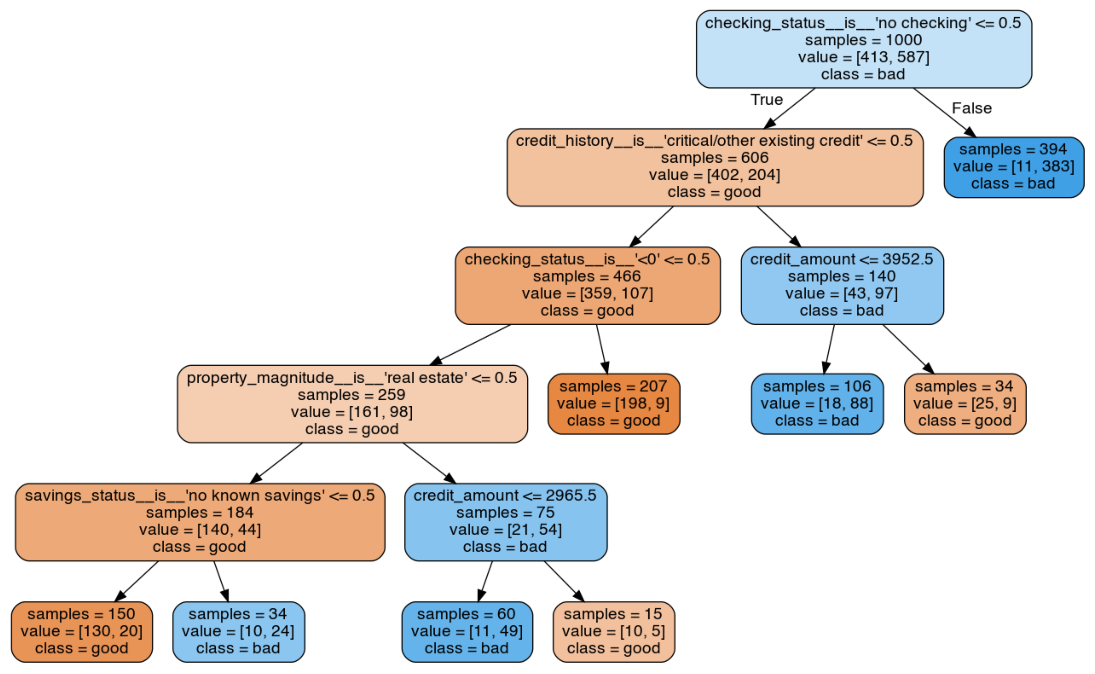

In [12]:
samples = identity_sampling(base)
dt = decision_tree(base, samples, 
                   # Liste des paramètres pour l'arbre de décision 
                   min_accuracy=.9, # minimum de précision exigée
                  )

display_decision_tree(dt, getattr(base, 'encoded_feature_names' ,base.feature_names), getattr(base, 'class_names', None))

### Coefficients de Pearson 

In [13]:
samples = identity_sampling(base) 
pcc = pearson_correlation(base, samples)
for class_name in pcc.keys():
    plot = fi_plot_bokeh(base, pcc[class_name])
    handle = show(plot, notebook_handle=True)
    
    # Update the plot title in the earlier cell
    plot.title.text = "Coefficient de Pearson pour la classe " + class_name
    push_notebook(handle=handle)

## Données textuelles (explications locales) 

In [14]:
base = AirlineBase() # other choices (tabular) : IrisBase, AdultBase, GermanBase, LoanBase

Les données textuelles sont représentées par des vecteurs de taille fixe. Les entrées correspondent à des mots. 

In [15]:
base.population.head(5)

0    1     2     3     4     5     6    7     8    9  ...  26  27  28  29  \
0  78   57  6739   215     0     0     0    0     0    0  ...   0   0   0   0   
1  78  542   580  1129  2488     1     2  194  6740    0  ...   0   0   0   0   
2  78    3   201    98   777   564     3   72     1  148  ...   0   0   0   0   
3  78   87   131  3725     1  4683  4684  987    15   21  ...   0   0   0   0   
4  78   10    87     4   131   470   208  489    80   20  ...   0   0   0   0   

   30  31  32  33  34  35  
0   0   0   0   0   0   0  
1   0   0   0   0   0   0  
2   0   0   0   0   0   0  
3   0   0   0   0   0   0  
4   0   0   0   0   0   0  

[5 rows x 36 columns]

In [16]:
base.display(base.population.head(5))

['virginamerica what dhepburn said', "virginamerica plus you've added commercials to the experience tacky", "virginamerica i didn't today must mean i need to take another trip", "virginamerica it's really aggressive to blast obnoxious entertainment in your guests' faces amp they have little recourse", "virginamerica and it's a really big bad thing about it"]


In [17]:
# randomly selects the scope of the explanation
scope = base.population.sample(1)
scope_pred = base.model(scope)
print("Sortie de l'algorithme : ", base.class_names[int(scope_pred[0])])
base.display(scope)

Sortie de l'algorithme :  negative
["usairways i just think if i am staying w your airline amp rescheduling a flight i shouldn't absorb a fee that is the cost of 12 my flight"]


### Sampling

L'échantillonnage se passe au niveau de la représentation des textes. 

In [18]:
base.display(perturb_one_sample_w_pop(base, scope, size=10)) # échange de mots avec des éléments de la population

['usairways i just think if i drop staying my your airline amp rescheduling a flight i in absorb a fee that to the cost of my flight', "usairways i would think if i am staying w your airline amp rescheduling a i shouldn't absorb a fee that is cost of 12 flight", "usairways i or twice if i hard staying w your airline amp work a flight i shouldn't absorb a fee that is cost of 12 my", "usairways i just think if i at staying w your rude amp rescheduling a flight i shouldn't absorb a your that is the cost flight", "usairways i been think hours i am you w your the plane rescheduling a flight i shouldn't 1533 a jfk this is the cost of 12 my flight", "usairways i just cancelled if i am staying now missing airline training rescheduling a happy i shouldn't absorb a fee is cost of", "usairways i just can't see i am i w your airline amp rescheduling a when i am paying a frustrating that the cost of my", "usairways i just think a return call by a human a flight i shouldn't absorb a fee is cost 12 m

In [19]:
base.display(select_closest(base, scope, size=10)) # selection des textes qui ressemblent le plus au périmètre de l'explication

['usairways this is ridiculous i have a 600 am flight and two hours of rest wasted', 'usairways just discovered that they billed us 300 for the rescheduled flight which cost me a second day of lost work', 'usairways is it possible to earn dividend miles for a passenger that is not me even if i am purchasing the tickets', 'usairways i have to spend more than the cost of the flight just to get a free room and transportation to and from the airport', 'usairways charging 200 2 change a flight is a rip off the reason i have 2 is out of my hands amp i want 2 reschedule same flight but in july', 'usairways your a miserable airline and your loss of revenue is a reflection of that go extinct a merger only delays the inevitable', 'usairways it is just bad practice and i am disappointed that your airline was not preparedhonestly the last time i fly with you guys', 'usairways this is the last time i use your airline i promise that', 'usairways flight is already over i think the airline should just

### Génération 

In [20]:
samples = perturb_one_sample_w_pop(base, scope, size=1000)
fi = feature_importance(base, scope, samples, alpha=0.02)
plot = fi_plot_bokeh(base, fi)
handle = show(plot, notebook_handle=True)

## Données images 

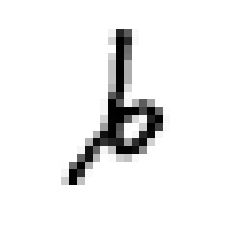

In [21]:
base = MnistBase()

scope = base.population.sample(1)
base.display(scope)

### Représentation des données

Deux représentations sont possibles pour les images. La première représentation permet d'échanger des morceaux d'image d'un échantillon à l'autre. Les valeurs dans les lignes font référence aux indices (dans population) de l'image avec laquelle on souhaite permuter. 

       0    1    2    3    4    5    6    7    8    9  ...  186  187  188  \
892  892  892  892  892  892  892  892  892  892  892  ...  892  892  892   

     189  190  191  192  193  194  195  
892  892  892  892  892  892  892  892  

[1 rows x 196 columns]


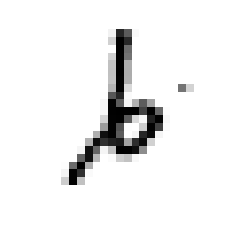

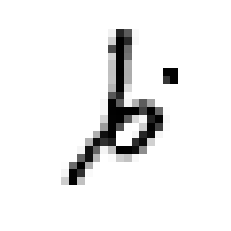

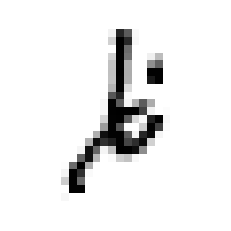

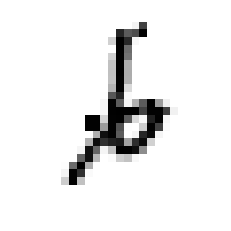

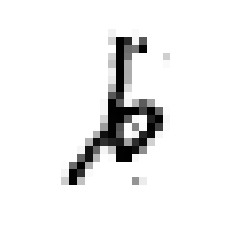

In [22]:
base.init_bpixel_representation(which='inversion')
print(scope)
base.display(perturb_one_sample_w_pop(base, scope, size=5, normal_sigma=10))

La deuxième représentation permet de flouter certaines parties de l'image. 

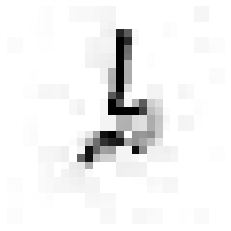

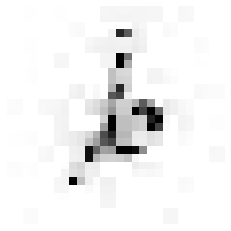

In [23]:
base.init_bpixel_representation(which='blur')
scope = base.update_scope(scope)
base.display(add_random_noise(base, scope, sigma=5, size=2))